## Import Modules


In [3]:
import pandas as pd
import numpy as np

from  cbcdb import DBManager
import datetime
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

## Read in Data

In [4]:
load_dotenv(find_dotenv())
db = DBManager()

In [136]:
sql = """
create temporary table consecutive_days as (
     select uid
     , datetime_
     , rank_group
     , visit_number
     , max(visit_number) over (partition by uid) as max_num_visit
     , case when (max_num_visit) > 1 then 1
     else 0 end as visit_more_than_once
     from (
          select uid
               , datetime_
               , rank_group
               , rank() over (partition by uid order by rank_group asc) as visit_number
          from (
               SELECT uid
                    , datetime                                                                      as datetime_
                    , dateadd(day, -rank() OVER (partition by uid ORDER BY datetime), datetime)     AS rank_group
               FROM (SELECT DISTINCT
                                        t.location_id || '_' || t.animal_id as uid
                                   , trunc(t.datetime_date) as datetime
                         from bi.transactions t
                              inner join bi.animals a
                                             on a.ezyvet_id = t.animal_id
                                             and a.location_id = t.location_id
                         order by 1, 2))));

create temporary table wellness as (
     select
               wm.location_id || '_' || wm.animal_id as uid
          , date(datetime_start_date) as datetime_
          , wm.wellness_plan as wellness_plan_num
          , DATEDIFF(MONTH, wm.datetime_start_date, CURRENT_DATE) as months_a_member
          , wp.name                                               as wellness_plan
     from bi.wellness_membership wm
               left join bi.wellness_plans wp
                    on wp.location_id = wm.location_id
                         and wp.ezyvet_id = wm.wellness_plan
               left join bi.animals a
                    on a.location_id = wm.location_id
                         and a.ezyvet_id = wm.animal_id
     where wp.active = 1
          and wm.status = 'Active');

select f1.uid
         , f1.breed
         , f1.ani_age
         , f1.date
         , f1.weight
         , f1.is_medical
         , f1.product_group
         , f1.type_id
         , f1.wellness_plan
         , f1.months_a_member
         , f1.visit_number
         , f1.visit_more_than_once
         , f1.max_num_visit
         , f1.first_visit_spend
         , f1.total_future_spend
        from(
        select f.uid
               , f.breed
               , f.ani_age
               , f.date
               , f.weight
               , f.is_medical
               --, f.tracking_level
               , f.product_group
               , f.type_id
               , cd.visit_number
               , cd.visit_more_than_once
               , cd.max_num_visit
               , case when w.wellness_plan is not null then 1 else 0 end as wellness_plan
               , w.months_a_member
               , sum(case when cd.visit_number != 1 then f.revenue else 0 end)
                    over (partition by f.uid) as total_future_spend
                , sum(case when cd.visit_number = 1 then f.revenue else 0 end)
                    over (partition by f.uid) as first_visit_spend
                from (
                    select t.location_id || '_' || t.animal_id as uid
                     , a.breed
                     , max(
                      date_diff('years', timestamp 'epoch' + a.date_of_birth * interval '1 second',
                                current_date))                                            as ani_age
                     , trunc(t.datetime_date)                                            as date
                     , a.weight
                     , p.is_medical
                     , p.product_group
                     , case when apt.type_id like 'Grooming%' then 'groom'
                            when apt.type_id like '%Neuter%' then 'neurtering'
                            when apt.type_id like '%ental%' then 'dental'
                            else apt.type_id end as type_id
                     --, p.name
                     --, p.type
                     --, p.tracking_level
                     , t.revenue                                                          as revenue
                     , dense_rank() over (partition by t.location_id || '_' || t.animal_id  order by trunc(t.datetime_date)  asc) as rank_
                    from bi.transactions t
                         inner join bi.products p
                                    on t.product_id = p.ezyvet_id
                                        and t.location_id = p.location_id
                         inner join bi.animals a
                                    on a.id = t.animal_id
                         left join bi.contacts c
                                   on a.contact_id = c.ezyvet_id
                                       and t.location_id = c.location_id
                        left join bi.appointments apt
                                   on a.contact_id = apt.ezyvet_id
                                       and t.location_id = apt.location_id
                --where p.name not like '%Subscri%'
                --  and p.product_group != 'Surgical Services'
                  --and a.breed != '0.0'
                group by 1, 2, 4, 5, 6, 7, 8,9) f

                   left join consecutive_days cd
                             on f.uid = cd.uid
                                 and f.date = cd.datetime_
                    left join wellness w
                            on f.uid = w.uid
                                and f.date = w.datetime_) f1
    where f1.visit_number = 1
    order by 1, 4"""
df = db.get_sql_dataframe(sql)
#df.to_csv('customer_retention_prod/data/data.csv')

2021-08-09 17:00:22,429| ERROR   | Password is required for key /Users/adhamsuliman/.ssh/id_rsa


In [137]:
df['total_future_spend'] = df.total_future_spend.apply(lambda x: 5000 if x > 5000 else x)
df['total_future_spend'] = df.total_future_spend.apply(lambda x: 0 if x < 0 else x)
df = df[((df.ani_age.notnull()) & (df.weight.notnull()))]

## Exploratoy Data Analysis
#### Amount of time between first and second appointment


df_valid = df[df.datetime<datetime.date(datetime.date.today().year-1 , datetime.date.today().month+6, datetime.date.today().day)]
#df_valid = df[df.datetime<datetime.date(datetime.date.today().year-1 , datetime.date.today().month, datetime.date.today().day)]
df = df.merge(df_valid['animal_id']).copy()

len(df.animal_id.unique())

In [138]:
len(df.uid.unique())

4359

sns.histplot(data=df[df.visit_number==1],x='datetime').set(title='First Visit')
plt.xticks(rotation=45)
plt.show()

df_visit_1 = df[df.visit_number == 1]
df_visit_2 = df[df.visit_number == 2]
df_diff = df_visit_1[['uid','datetime']].merge(df_visit_2[['uid','datetime']], on='uid').drop_duplicates()
df_diff['date'] = df_diff.apply(lambda x: x.datetime_y -x.datetime_x, axis = 1 )
df_diff['date'].astype('timedelta64[D]').plot.hist(bins = 50).set(title='Number of Days Between Visit')
plt.xticks(np.arange(0, 300, 30), rotation=45)
#plt.yticks(np.arange(0,16,1))

## Remove records where species equivalent to 0.0 and weight equivalent to

In [139]:
df[['uid','breed']].drop_duplicates().breed.nunique()

762

working = ['Alaskan Malamute', 'Siberian Huskie','husky', 'Great Dane', 'Doberman', 'Rottweiler', 'Akita', 'Anatolian Shepherd', 'Huskie', 'Saint Bernard', 'Mastiff', 'Bernard','Portuguese Water Dog', 'German Pinscher', 'Great Pyrenee', 'Giant Schnauzer', 'Greater Swiss Mountain Dog', 'Newfoundland', 'Samoyed', 'Bullmastiff', 'Bernese Mountain Dog','mountain curr','point','Large']
herding =  ['Australian Cattle Dog', 'Australian Shepherd', 'Collie', 'Shetland Sheepdog', 'Pembroke Welsh Corgi', 'Cardigan Welsh Corgi', 'Old English Sheepdog', 'Belgian Tervuren', 'Canaan Dog', 'Briard', 'Bouvier des Flandre', 'Belgian Malinoi', 'German Shepherd','corgi','boxer','sheep','shep','aussie','shetland','auusie']
hound = ['Basset Hound', 'Saluki', 'Beagle', 'Harrier', 'American Foxhound', 'English Foxhound', 'Bloodhound', 'Irish Wolfhound', 'Dachshund', 'Otterhound', 'Norwegian Elkhound', 'Greyhound', 'Italian Greyhound', 'Whippet', 'Afghan Hound', 'Borzois Hound', 'Coonhound', 'Rhodesian Ridgeback', 'Petit Basset Griffon Vendéen', 'Basenji','hound']
sporting = ['Cocker', 'Irish Setter',  'English Springer Spaniel', 'Clumber Spaniel', 'German Shorthaired Pointer', 'German Wirehaired Pointer', 'American Water Spaniel', 'Weimaraner', 'Retriever', 'Chesapeake Bay Retriever', 'English Setter', 'staffordshire']
non_sporting =  ['Dalmatian', 'Chow Chow', 'Finnish Spitz', 'Shar Pei', 'American Bulldog', 'Poodle', 'Boston Terrier', 'Lhasa Apso', 'Shiba Inu', 'French Bulldog', 'Schipperke', 'American Eskimo Dog']
toy =  ['Chihuahua', 'Pomeranian', 'Maltese', 'Cavalier King Charles Spaniel', 'Silky Terrier', 'Chinese Crested Dog', 'Miniature Schnauzer', 'Bichon Frise', 'Yorkshire Terrier', 'Pekingese', 'Shih Tzu', 'Japanese Chin', 'Havanese', 'Miniature Pinscher', 'Brussels Griffon', 'Papillon', 'Affenpinscher', 'Pug','doodle','yorkie','shih','shitzu','poo','schnoodle','mini aussie','crested','pom','shorkie','mini','teddy','small','chorkie','chi','tibetan','dachs','toy','bichon','yorki']
terrier =  ['Airedale Terrier', 'American Staffordshire Terrier', 'Jack Russell', 'Bull Terrier', 'pit bull', 'pitbull' 'Fox Terrier', 'Wheaten Terrier', 'Cairn Terrier', 'West Highland White Terrier', 'Australian Terrier', 'Border Terrier', 'Staffordshire Bull Terrier', 'Bedlington Terrier', 'Kerry Blue Terrier', 'Rat Terrier', 'Scottish Terrier','Bull','blue terr', "terrier",'pit']
companion = ['mutt', 'goldon', 'Lab']
cat =  ['cat','siamese'] 


working = [x.lower() for x in working]
herding =  [x.lower() for x in herding]
hound = [x.lower() for x in hound]
sporting = [x.lower() for x in sporting]
non_sporting = [x.lower() for x in non_sporting]
toy = [x.lower() for x in toy]
terrier = [x.lower() for x in terrier]

df['working'] = df['breed'].apply(lambda x: 1 if any(ext in x.lower() for ext in working) else 0)
df['herding'] = df['breed'].apply(lambda x: 1 if any(ext in x.lower() for ext in herding) else 0)
df['hound'] = df['breed'].apply(lambda x: 1 if any(ext in x.lower() for ext in hound) else 0)
df['sporting'] = df['breed'].apply(lambda x: 1 if any(ext in x.lower() for ext in sporting) else 0)
df['non_sporting'] = df['breed'].apply(lambda x: 1 if any(ext in x.lower() for ext in non_sporting) else 0)
df['toy'] = df['breed'].apply(lambda x: 1 if any(ext in x.lower() for ext in toy) else 0)
df['terrier'] = df['breed'].apply(lambda x: 1 if any(ext in x.lower() for ext in terrier) else 0)
df['cat'] = df['breed'].apply(lambda x: 1 if any(ext in x.lower() for ext in cat) else 0)

print(df[((df.working != 1) & (df.herding != 1) &  (df.hound != 1) & (df.sporting != 1) & (df.non_sporting != 1) & (df.toy != 1) & (df.terrier != 1) & (df.cat != 1))].breed.nunique(), 
df[((df.working != 1) & (df.herding != 1) &  (df.hound != 1) & (df.sporting != 1) & (df.non_sporting != 1) & (df.toy != 1) & (df.terrier != 1)& (df.cat != 1))].breed.unique())

df[((df.working == 1) | (df.herding == 1) |  (df.hound == 1) | (df.sporting == 1) | (df.non_sporting == 1) | (df.toy == 1) | (df.terrier == 1))].breed.unique()

In [140]:
print(
    f" Original # of animals: {len(df)}", '\n',
    f"# of animal with weight = 0: {len(df[df.weight==0.0])}", '\n',
    f"# of animal with species = 0: {len(df[df.breed=='0.0'])}")

df = df[((df.weight!=0.0)&(df.breed!='0.0'))]

 Original # of animals: 15320 
 # of animal with weight = 0: 4964 
 # of animal with species = 0: 44


In [141]:
df.columns

Index(['uid', 'breed', 'ani_age', 'date', 'weight', 'is_medical',
       'product_group', 'type_id', 'wellness_plan', 'months_a_member',
       'visit_number', 'visit_more_than_once', 'max_num_visit',
       'first_visit_spend', 'total_future_spend'],
      dtype='object')

In [165]:
#df_product = pd.get_dummies(df1.name)
df_ = df[df.visit_number==1][['uid','ani_age','weight','is_medical','product_group','type_id','wellness_plan','first_visit_spend','total_future_spend']]
print(df_[['uid','ani_age','weight','first_visit_spend','total_future_spend','is_medical']].drop_duplicates().shape)
df_main = df_.groupby(['uid','ani_age','weight','first_visit_spend','total_future_spend'], as_index=False)['is_medical'].max()
df_main.shape

(3238, 6)


(2973, 6)

In [166]:
df_product_group = pd.get_dummies(df_.product_group)
df_type = pd.get_dummies(df.type_id)
df_ = pd.concat([df_[['uid']],
                df_type, 
                df_product_group], axis = 1)#.fillna(0)
df__ = df_.groupby(['uid']).sum()
df_final = df_main.merge(df__, 
                on = 'uid',)
print(df_final.shape)

(2973, 71)


Annual/Wellness Exam',\n 'Cancellation',\n 'Drop Off',\n 'Euthanasia',\n 'Exam - New Patient (Adult)',\n 'Exam - New Puppy/Kitten',\n 'Exam - Post-Op Recheck',\n 'Exam - Puppy/Kitten Boosters',\n 'Exam and Vaccination Booster',\n 'House Call - Appointments',\n 'Recheck',\n 'Sedated Radiographs',\n 'Sick Exam',\n 'Surgery',\n 'Surgery - Dog Spay (40min)',\n 'Surgery - Soft Tissue - (60min)',\n 'Surgery - Soft Tissue - (90min)',\n 'Surgery Recheck',\n 'Tech Appointment',\n 'VetsNow Referral In Person',\n 'VetsNow Referral Pet Taxi',\n 'dental',\n 'groom',\n 'neurtering',\n 'Add- On Services',\n 'Administration',\n 'Anesthesia & Sedation',\n 'Boarding ',\n 'Breeder/Rescue Packages',\n 'Daycare',\n 'Daycare Packages',\n 'Dentistry & Oral Surgery',\n 'Diagnostics',\n 'Euthanasia & Cremation',\n 'Grooming (Full Service)',\n 'Hospital Supplies',\n 'Imaging',\n 'Laboratory - Antech',\n 'Laboratory - In-house',\n 'Medications - Injectable',\n 'Medications - Oral',\n 'Medications - Topical',\n 'Parasite Control',\n 'Professional Services',\n 'Promotions',\n 'RX Diets',\n 'Referrals - C2C',\n 'Referrals - E2C',\n 'Retail (Baked Goods)',\n 'Retail (Cat Food)',\n 'Retail (Dog Food)',\n 'Retail (Medical Crossover)',\n 'Retail (Other)',\n 'Retail (Plush Toys)',\n 'Retail (Rawhide/Dental)',\n 'Retail (Toys)',\n 'Retail (Treats)',\n 'Staff Bath',\n 'Supplements/OTCs',\n 'Surgical Services',\n 'Tips',\n 'To Print',\n 'Vaccinations',\n 'Wellness Plan Fees',\n 'to print']"

In [167]:
        bins = [0, 100, 200, 300, 1000, 99999]
        labels = [0, 1, 2, 3, 4]
        df_final['total_future_spend_bin'] = pd.cut(df_final['total_future_spend'], bins=bins, include_lowest=True,labels=labels)
        print(f"Value Counts for labels: {df_final['total_future_spend_bin'].value_counts()}")

ValueError: Bin edges must be unique: array([   0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
         60.   ,  148.234,  300.66 ,  608.   , 5000.   ]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [278]:
final_columns = list(df_final.columns)
for i in ['uid','total_future_spend','total_future_spend_bin']:
    final_columns.remove(i)

X = df_final[final_columns]
y = df_final['total_future_spend'].apply(lambda x: int(x))
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .2,
                                                    random_state = 42)

In [279]:
# Below will fail with a perfect separation error
res = sm.OLS(y_train, X_train).fit()
#res.params

#res2 = sm.GLM(y_train, Xs, family=sm.families.Binomial()).fit_regularized(L1_wt=0.0, alpha=0.1)
#params = res2.params

In [280]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     total_future_spend   R-squared (uncentered):                   0.611
Model:                            OLS   Adj. R-squared (uncentered):              0.064
Method:                 Least Squares   F-statistic:                              1.116
Date:                Thu, 29 Jul 2021   Prob (F-statistic):                       0.191
Time:                        21:56:36   Log-Likelihood:                         -3858.9
No. Observations:                 532   AIC:                                      8340.
Df Residuals:                     221   BIC:                                      9670.
Df Model:                         311                                                  
Covariance Type:            nonrobust                                                  
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
weight                                       3.2336      1.540      2.099      0.037       0.198       6.269
ani_age                                      6.1064      7.964      0.767      0.444      -9.588      21.801
revenue                                      1.0063      0.506      1.990      0.048       0.010       2.003
Airedale Terrier                           -81.7287     95.163     -0.859      0.391    -269.271     105.814
Akita                                     -341.3651    537.077     -0.636      0.526   -1399.813     717.083
Alaskan Malamute                           101.0838    207.891      0.486      0.627    -308.619     510.787
American Bulldog                          -246.7355    574.653     -0.429      0.668   -1379.236     885.765
American Bulldog mix                        -3.6218    161.743     -0.022      0.982    -322.377     315.134
American Bulldog,                        -1.072e-11   2.61e-11     -0.412      0.681   -6.21e-11    4.06e-11
American Bully Wht/Tan                     189.0931    118.866      1.591      0.113     -45.163     423.349
American Eskimo Dog                        274.9846    142.129      1.935      0.054      -5.117     555.086
American Foxhound                        -1.945e-11   4.55e-11     -0.428      0.669   -1.09e-10    7.01e-11
American Long Hair                         -25.7840    136.764     -0.189      0.851    -295.312     243.744
American Pit Bull                        -5.746e-12   2.29e-11     -0.251      0.802   -5.09e-11    3.94e-11
American Shorthair                          23.9107     89.615      0.267      0.790    -152.698     200.520
American Staffordshire Terrier             -27.8274     51.243     -0.543      0.588    -128.816      73.161
American Staffordshire Terrier mix        9.672e-12   2.55e-11      0.380      0.705   -4.05e-11    5.99e-11
American Terrier                            16.0612    534.979      0.030      0.976   -1038.252    1070.374
Auss. Labradoodle Chocolate                -14.7949     72.809     -0.203      0.839    -158.284     128.694
Aussie-doodle                              -82.6710    139.397     -0.593      0.554    -357.388     192.046
Australian Cattle Dog                      -46.8361    105.137     -0.445      0.656    -254.036     160.364
Australian Cattle Dog Mix                -2.709e-12   5.76e-11     -0.047      0.963   -1.16e-10    1.11e-10
Australian Lab mix Blck                    -13.5050    185.612     -0.073      0.942    -379.302     352.292
Australian Shepherd                         -3.7370     92.661     -0.040      0.968    -186.350     178.876
Australian Shepherd Tri Red              

In [281]:
import sklearn.metrics as metrics
#Generate predictions with the model using our X values
y_pred = res.predict(X_test)
y_pred = [0 if x < 0 else x for x in y_pred]
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
#print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 347.4928550482418
MSE: 369162.7514484207
RMSE: 607.5876491901565


In [272]:
y_test = list(y_test)

In [ ]:

# a list contains both even and odd numbers. 
seq = [0, 1, 2, 3, 5, 8, 13]
  
# result contains odd numbers of the list
result = filter(lambda x: x % 2 != 0, seq)

<AxesSubplot:ylabel='Density'>

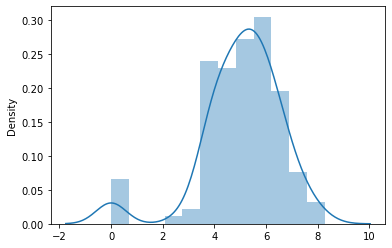

In [290]:
import seaborn
y_test_ = [np.log(x) if x != 0 else 0 for x in y_test]
seaborn.distplot(a=y_test_)

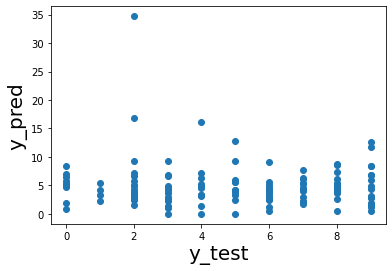

In [275]:
import matplotlib.pyplot as plt
residuals =  np.array(y_test) - np.array(y_pred)
plt.scatter(y_test,y_pred)
plt.xlabel("y_test", size = 20)
plt.ylabel("y_pred", size = 20)
plt.show()

In [259]:
model = Sequential()
model.add(Dense(256, input_dim=X.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
es = EarlyStopping(monitor='mse', mode='min', verbose=1, patience=3)
model.fit(X_train,
            y_train,
            epochs = 100,
            batch_size = 10,
            validation_split = .2,
            callbacks = [es])

Train on 425 samples, validate on 107 samples
Epoch 1/100
425/425 [==============================] - 1s 2ms/sample - loss: 37.7808 - mse: 37.7808 - val_loss: 25.4920 - val_mse: 25.4920
Epoch 2/100
425/425 [==============================] - 0s 425us/sample - loss: 11.7007 - mse: 11.7007 - val_loss: 24.7243 - val_mse: 24.7243
Epoch 3/100
425/425 [==============================] - 0s 439us/sample - loss: 10.1983 - mse: 10.1983 - val_loss: 23.8667 - val_mse: 23.8667
Epoch 4/100
425/425 [==============================] - 0s 466us/sample - loss: 8.9221 - mse: 8.9221 - val_loss: 24.9547 - val_mse: 24.9547
Epoch 5/100
425/425 [==============================] - 0s 431us/sample - loss: 8.7796 - mse: 8.7796 - val_loss: 33.8252 - val_mse: 33.8252
Epoch 6/100
425/425 [==============================] - 0s 486us/sample - loss: 8.6689 - mse: 8.6689 - val_loss: 26.1844 - val_mse: 26.1844
Epoch 7/100
425/425 [==============================] - 0s 500us/sample - loss: 7.2521 - mse: 7.2521 - val_loss: 26.2

In [230]:
import sklearn.metrics as metrics
#Generate predictions with the model using our X values
y_pred = model.predict(X_test)
y_pred = [0 if x < 0 else x[0] for x in y_pred]
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred)

print("Results of sklearn.metrics:")
print("MAE:",np.round(mae,1))
print("MSE:", np.round(mse,1))
print("RMSE:", np.round(rmse,1))
print("R-Squared:", np.round(r2,2))

Results of sklearn.metrics:
MAE: 2.8
MSE: 11.6
RMSE: 3.4
R-Squared: -0.46


In [231]:
len(X_train)

532

In [232]:
len(X_test)

133